In [1]:
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

In [2]:
import json
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from nltk.draw.dispersion import dispersion_plot

In [3]:
import pandas as pd
from wordcloud import WordCloud
import json

with open('sampled_comments.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.DataFrame(data)

# Convert non-string values and NaN to empty strings in 'title' column
df['title'] = df['title'].astype(str)

In [4]:
# Create a WordCloud from hashtags in titles
hashtags = df['title'].str.findall(r'#\w+').explode().str.lower().astype(str)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(hashtags))

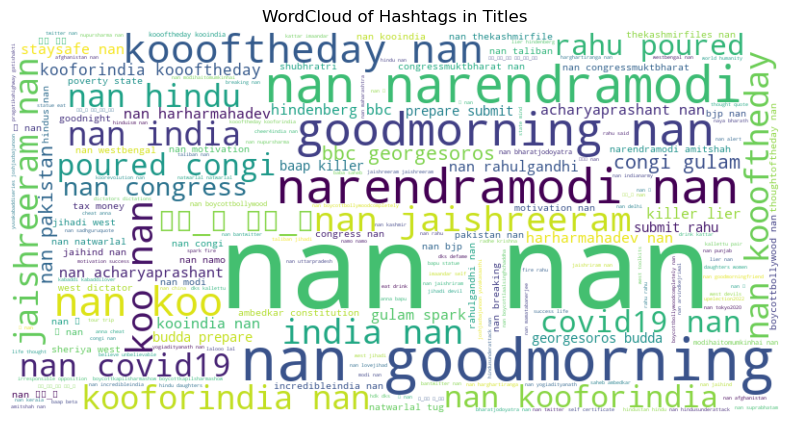

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Hashtags in Titles')
plt.show()

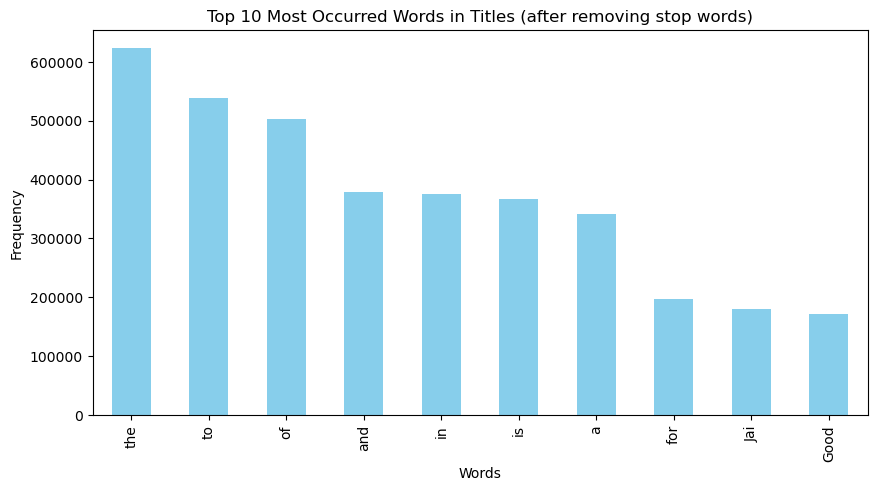

In [6]:
top_words = pd.Series(' '.join(df['title']).split()).value_counts().nlargest(10)
top_words.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Top 10 Most Occurred Words in Titles (after removing stop words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/student/anaconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


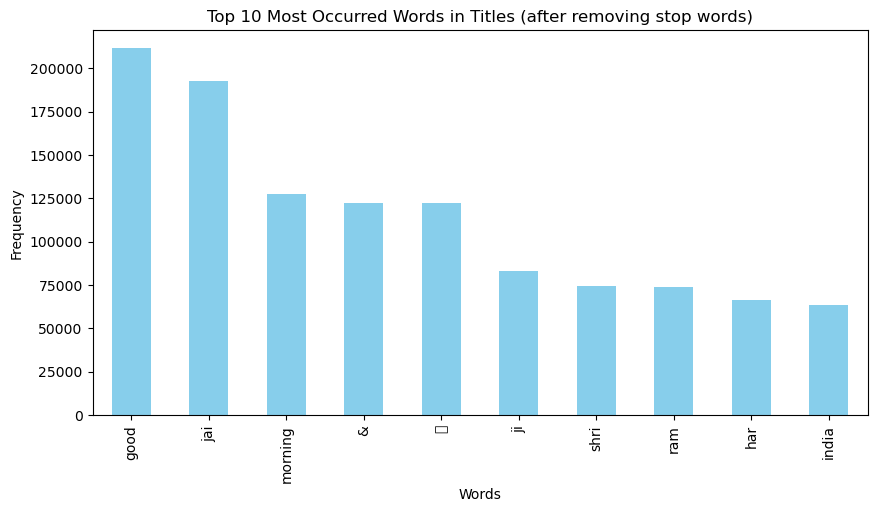

In [7]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Exclude stopwords from the top words list
filtered_top_words = pd.Series([word.lower() for word in df['title'].str.split().explode() if isinstance(word, str) and word.lower() not in stop_words]).value_counts().nlargest(10)

# Plot the filtered top words
filtered_top_words.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Top 10 Most Occurred Words in Titles (after removing stop words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [8]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
## Lematization
nltk.download('wordnet')

/home/student/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-13 14:41:26.110770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 14:41:26.332382: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 14:41:27.391952: W tensorflow/compiler/xla/stream_executor/

True

In [13]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...


In [14]:
df = pd.read_json('filtered_comments.json', lines=True)
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to assign sentiment labels using VADER
def get_sentiment(text):
    # Analyze the sentiment of the text
    sentiment_scores = sid.polarity_scores(text)
    # Determine the sentiment label based on the compound score
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Assign sentiment labels to your data
df['sentiment'] = df['cleaned_title'].apply(get_sentiment)

In [17]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_title'], df['sentiment'], test_size=0.2, random_state=42)

In [19]:
# Initialize TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=word_tokenize, lowercase=True)

In [36]:
# Save the TfidfVectorizer to a pickle file
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [20]:
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [22]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

In [23]:
# Predict the labels for the test set
y_pred = svm_model.predict(X_test_tfidf)

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9984657479617157
Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.75      0.81       444
     neutral       1.00      1.00      1.00    356593
    positive       0.94      0.96      0.95      4051

    accuracy                           1.00    361088
   macro avg       0.94      0.90      0.92    361088
weighted avg       1.00      1.00      1.00    361088



In [26]:
import pickle

# Save the SVM model to a pickle file
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
import pickle

In [32]:
# Load the SVM model from the pickle file
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

In [35]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

def clean_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ''.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s#]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Define contractions and their expansions
    contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had ",
    "he'll": "he will",
    "he's": "he is ",
    "I'd": "I had ",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mustn't": "must not",
    "must've": "must have",
    "needn't": "need not",
    "shan't": "shall not",
    "she'd": "she had",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'll": "that will",
    "that's": "that is",
    "there's": "there is ",
    "they'd": "they had",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is ",
    "what've": "what have",
    "where's": "where is ",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is / who has",
    "who've": "who have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": " you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
}


    # Replace contracted words with their expansions
    text = ''.join([contractions.get(word, word) for word in text.split()])

    return text

def clean_dataframe(df, title):
    df['title'] = df['title'].apply(clean_text)

clean_dataframe(df, 'title')

In [39]:
import pickle

# Load the SVM model from the pickle file
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Example text input
text = "I love you."
preprocessed_text = clean_text(text)  

# Load the TfidfVectorizer used during training
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Transform the preprocessed text into numerical features
numerical_features = tfidf_vectorizer.transform([preprocessed_text])

# Apply the SVM model to classify the numerical features
predicted_label = svm_model.predict(numerical_features)

# Print the predicted label
print("Predicted label:", predicted_label[0])


Predicted label: positive
